In [34]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d

from pyfusion.data import load

In [35]:
SLICE = 70
KERNEL_SIZE = 3
NOISE_SCALE = 0.2   # sigma
INTEGRATION_SCALE = 10   # rho
ALPHA = 0.001

ITERATIONS = 1000
STEP_SIZE = 1

In [36]:
def gaussian(std_dev: float, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Generate a Gaussian kernel.
    """
    return np.exp(-(x**2 + y**2) / (2 * std_dev**2)) / (2 * np.pi * std_dev**2)


def dx_gaussian(std_dev: float, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Compute the derivative of a Gaussian kernel with respect to x.
    """
    return -x * gaussian(std_dev, x, y) / (std_dev**2)


def dy_gaussian(std_dev: float, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Compute the derivative of a Gaussian kernel with respect to y.
    """
    return -y * gaussian(std_dev, x, y) / (std_dev**2)

def lambda_func(mu_1, mu_2):
    """
    Compute the second eigenvalue based on the first eigenvalue and the second mean, if mu_1 and mu_2 are not close.
    """
    return ALPHA + (1-ALPHA) * np.exp(-1/(mu_1 - mu_2)**2)

In [37]:
#type: ignore
def plot(data, title=None):
    """
    Plot the data with optional title and axis labels.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap="gray")
    if title:
        plt.title(title)
    plt.axis("off")
    plt.colorbar()
    plt.show()

In [38]:
FSL = load.load_fsl("../data/example_mri", SLICE)
FA_noisy = FSL.FA + 0.2 * FSL.FA.std() * np.random.randn(*FSL.FA.shape)

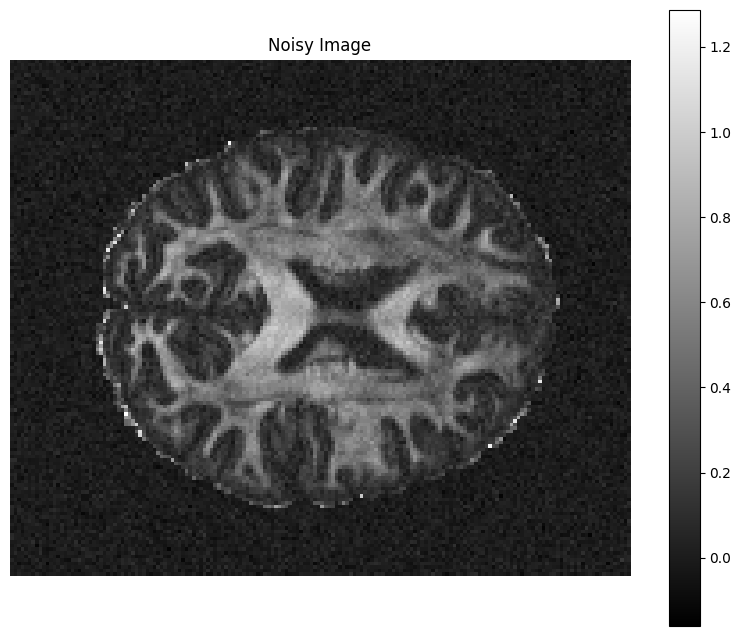

In [39]:
plot(FA_noisy, title="Noisy Image")

In [40]:
coord = np.linspace(-(KERNEL_SIZE - 1) / 2, (KERNEL_SIZE - 1) / 2, KERNEL_SIZE)
x, y = np.meshgrid(coord, coord)

# Create the Gaussian kernels
Gx_noise = dx_gaussian(NOISE_SCALE, x, y)   # \partial x K_\sigma
Gy_noise = dy_gaussian(NOISE_SCALE, x, y)   # \partial y K_\sigma

G_integration = gaussian(INTEGRATION_SCALE, x, y)   # K_\rho

K_x = convolve2d(Gx_noise, G_integration, boundary="fill")
K_y = convolve2d(Gy_noise, G_integration, boundary="fill")

In [41]:
img = FA_noisy.copy()

for _ in range(ITERATIONS):
    a = convolve2d(img, K_x, mode="same", boundary="symm")
    c = convolve2d(img, K_y, mode="same", boundary="symm")
    b = a * c

    mu_1 = np.zeros(img.shape)
    mu_2 = np.zeros(img.shape)
    alpha_1 = np.zeros(img.shape)
    
    discriminant = np.sqrt((a - c) ** 2 + 4 * (b**2))
    v = np.stack((2 * b, c - a + discriminant), axis=-1)
    
    alpha_1 = np.arctan2(v[..., 1], v[..., 0])
    mu_1 = (a + c + discriminant) / 2
    mu_2 = (a + c - discriminant) / 2

    lambda_1 = ALPHA
    lambda_2 = np.zeros_like(mu_2)

    mask = np.isclose(mu_1, mu_2)
    lambda_2[mask] = ALPHA
    lambda_2[~mask] = lambda_func(mu_1[~mask], mu_2[~mask])

    A = lambda_1 * np.cos(alpha_1)**2 + lambda_2 * np.sin(alpha_1)**2
    B = (lambda_1 - lambda_2) * np.cos(alpha_1) * np.sin(alpha_1)
    C = lambda_1 * np.sin(alpha_1)**2 + lambda_2 * np.cos(alpha_1)**2

    D_x = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]])  / 32
    D_y = np.array([[3, 10, 3], [0, 0, 0], [-3, -10, 3]]) / 32

    j_1 = A * convolve2d(img, D_x, mode="same", boundary="symm") + B * convolve2d(img, D_y, mode="same", boundary="symm")
    j_2 = B * convolve2d(img, D_x, mode="same", boundary="symm") + C * convolve2d(img, D_y, mode="same", boundary="symm")

    delta = convolve2d(j_1, D_x, mode="same", boundary="symm") + convolve2d(j_2, D_y, mode="same", boundary="symm")

    img += STEP_SIZE * delta

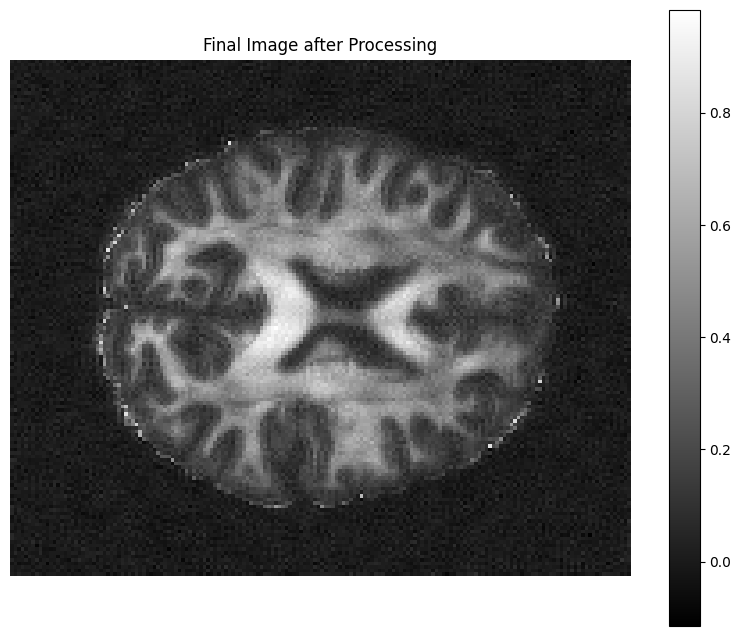

In [42]:
plot(img, title="Final Image after Processing")

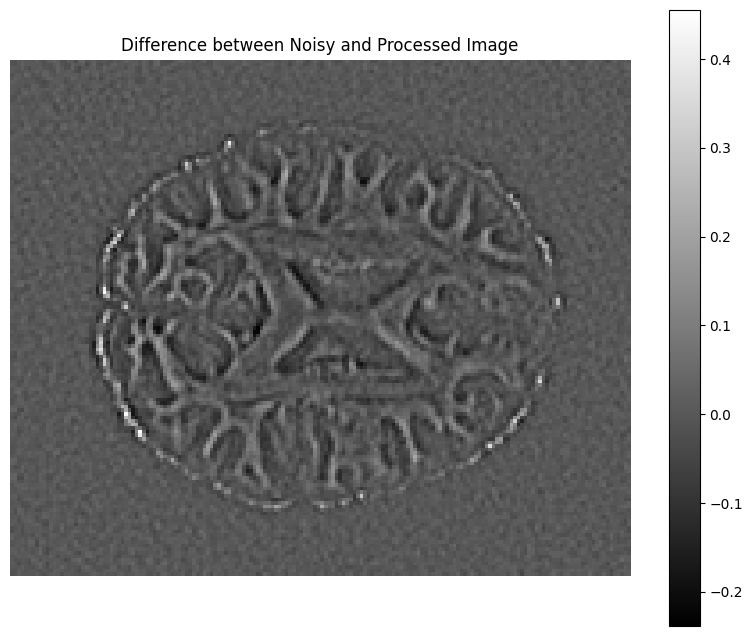

In [43]:
plot(FA_noisy-img, title="Difference between Noisy and Processed Image")

In [44]:
# stats
np.std(FA_noisy - img)

np.float64(0.04188581661001773)